<a href="https://colab.research.google.com/github/leonorebovy/heart_attack_predict_ingef/blob/main/HA_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Attack Prediction

### Data
The attached data contains a survey that was collected in 2007 in the United States by the CDC, where each row describes one person.  

### Exercise
Use machine learning models on the given data to analyze causing factors for heart attack. 





`Author: Leonore Bovy`


## Part 0: Data exploration and prep

In [34]:
## Import modules
import numpy as np # linear algebra
import pandas as pd
import numpy as np
import copy
import math
import statsmodels.api as sm

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

# Model building
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

!pip install catboost
from catboost import CatBoostClassifier

In [5]:
## Read in the data
# Please note that the data was loaded via google drive, change path accordingly.
data = pd.read_csv("drive/My Drive/Arthritis_on_heart_attack.csv")
data.head()

# Create a copy of original
copy.copy(data)
copy_orig_data = copy.copy(data)
copy_orig_data

,Unnamed: 0,arthritis.type,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,heart.attack
0,1,Non-arthritis,Male,"(25,80]",No,No,"(50,70]",School,Married,Moderate,Yes,No,Fair,No,No
1,2,Non-arthritis,Male,"(0,25]",No,No,"(19.9,50]",High.School,Not.married,No,Yes,No,Good,No,No
2,3,Non-arthritis,Male,"(25,80]",No,Yes,"(50,70]",High.School,Married,No,Yes,Yes,Good,Yes,No
3,4,Rheumatoid arthritis,Male,"(25,80]",Yes,No,"(50,70]",College,Married,No,Yes,Yes,Poor,Yes,No
4,5,Non-arthritis,Female,"(25,80]",No,No,"(19.9,50]",High.School,Married,Moderate,No,No,Fair,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3783,3784,Non-arthritis,Male,"(25,80]",Yes,Yes,"(50,70]",High.School,Married,No,Yes,Yes,Good,Yes,No
3784,3785,Non-arthritis,Male,"(25,80]",No,No,"(19.9,50]",College,Married,No,Yes,No,Fair,Yes,No
3785,3786,Non-arthritis,Male,"(25,80]",No,Yes,"(50,70]",School,Married,High,Yes,Yes,Poor,No,No
3786,3787,Non-arthritis,Female,"(25,80]",No,Yes,"(19.9,50]",High.School,Married,High,No,No,Good,Yes,No


In [6]:
## Data exploration
# Check for data types 
data.info()
data.describe()

# How many have heart attack?
data['heart.attack'].value_counts()

# Checking for missing values
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3788 entries, 0 to 3787
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3788 non-null   int64 
 1   arthritis.type     3788 non-null   object
 2   gender             3788 non-null   object
 3   bmi                3788 non-null   object
 4   diabetes           3788 non-null   object
 5   smoke              3788 non-null   object
 6   age                3788 non-null   object
 7   education          3788 non-null   object
 8   marriage           3788 non-null   object
 9   physical.activity  3788 non-null   object
 10  medical.access     3788 non-null   object
 11  blood.pressure     3788 non-null   object
 12  healthy.diet       3788 non-null   object
 13  covered.health     3788 non-null   object
 14  heart.attack       3788 non-null   object
dtypes: int64(1), object(14)
memory usage: 444.0+ KB


Unnamed: 0           0
arthritis.type       0
gender               0
bmi                  0
diabetes             0
smoke                0
age                  0
education            0
marriage             0
physical.activity    0
medical.access       0
blood.pressure       0
healthy.diet         0
covered.health       0
heart.attack         0
dtype: int64

## Interim evaluation
It looks like there a no missing values in our dataset (yay!)

Of all 3788 patients, 3678 have no heart attack and 110 do have a heart attack. That means our data is not very balanced, which could lead to problems in the model predictions later on. 

It looks like the data is stored in categorical variables. Better work with numerically-coded variables as model input, therefore I will transform them accordingly. The copy of the original data can be used to deduce which codes belong to which category.


In [7]:
from scipy.stats import chi2_contingency
## Data wrangling
## Convert variables from object to categorical
data[data.select_dtypes(['object']).columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
## Convert variables from categorical to code
data[data.select_dtypes(['category']).columns] = data.select_dtypes(['category']).apply(lambda x: x.cat.codes)

## Remove the first column (uninformative)
data = data.iloc[: , 1:]

## Those variables that are not dummy coded yet (i.e. only have 1/0 values) need to be transformed as well
data = pd.get_dummies(data, columns=['age', 'education', 'physical.activity', 'healthy.diet'], drop_first=True)

data.head(15)

,arthritis.type,gender,bmi,diabetes,smoke,marriage,medical.access,blood.pressure,covered.health,heart.attack,age_1,age_2,education_1,education_2,physical.activity_1,physical.activity_2,healthy.diet_1,healthy.diet_2
0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0
2,0,1,1,0,1,0,1,1,1,0,1,0,1,0,0,1,1,0
3,1,1,1,1,0,0,1,1,1,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
5,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,1,1,0
6,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1
7,0,1,1,0,0,0,1,1,1,0,0,1,0,1,0,1,1,0
8,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
9,0,0,1,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0


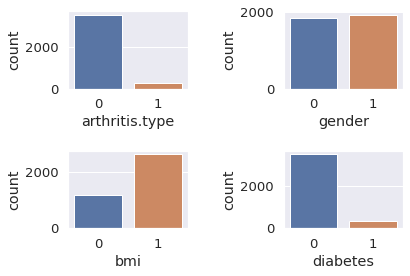

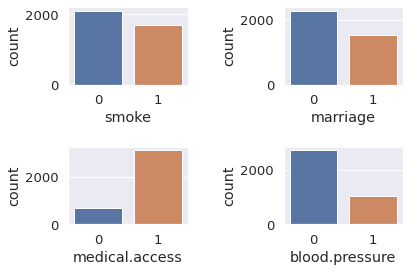

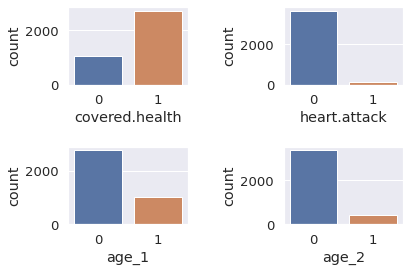

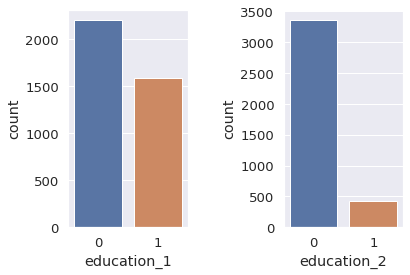

In [8]:
# plots multiple seaborn countplots on different subplots.
# source: https://www.justintodata.com/how-to-use-python-seaborn-for-exploratory-data-analysis/

sns.set(font_scale=1.2)

def plot_multiple_countplots(df, cols):
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    plt.subplots_adjust(hspace = 0.8)
    plt.subplots_adjust(wspace = 0.8)

    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                sns.countplot(x=df[col], ax=axs)
            else:
                sns.countplot(x=df[col], ax=axs[j])
        else:
            sns.countplot(x=df[col], ax=axs[i, j])
            
# Define all the columns we want to plot
col_to_be_plotted = list(data.columns.values)

# Plot per 4 variables for better overview
plot_multiple_countplots(data,col_to_be_plotted[0:4])
plot_multiple_countplots(data,col_to_be_plotted[4:8])
plot_multiple_countplots(data,col_to_be_plotted[8:12])
plot_multiple_countplots(data,col_to_be_plotted[12:14])

## Interim evaluation
It seems a small minority of the sample has arthritis. Most have a high BMI, but no diabetes. Most are young (<50), are married and have college or high school education. Most perform no physical activity. Not sure what binary blood pressure variable means (blood pressure issues yes/no?). Most rated their diet as good. Medical data is available for most and they are insured.
The dataset contains roughly equal males and females and equal amount of smokers.

## Part 1: Is it possible to predict heart-attack based on the given features?

Since heart attack (HA) is our outcome measurement and it is coded binary, we could try to predict using for example a simple logistic regression but also tree-based models (such as gradient boosting), neural networks or support vector machines could be used. 
Conceptually it would make sense to be able to predict HA from variables such as age (Lloyd-Jones et al., 2006), BMI (Flint et al., 2010), smoking status (Lee & Son, 2019) etc.

References:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6696428/

https://www.ahajournals.org/doi/full/10.1161/circulationaha.105.548206

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2992336/



So yes, theoretically it should be possible to predict heart-attack based on the given features and the data types. The next question would be how successfully such a model can predict HA :-)

The low number of cases that have a HA could lead to problems. Let's first try to predict heart rate with the given variables using simple logistic regression.


### Data splitting


In [10]:
## Create two datasets containing all either the data except the outcome (HA) variable, or only the outcome variable
X = data.drop('heart.attack', axis=1)
y = data['heart.attack']

## Here we perform the split
# Use default split size
# Add a random state for reproducibility
# Since our outcome variable is unbalanced, we should stratisfy the split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

## Looks balanced between train and test!
y_train.value_counts()[1]/ y_train.value_counts()[0] #0.029720
y_test.value_counts()[1] / y_test.value_counts()[0]  #0.030467

0.030467899891186073

### Logistic regresssion

In [11]:
## Run Logistic regression (default settings)
log_regr = LogisticRegression()
log_regr.fit(X_train, y_train)

LogisticRegression()

In [12]:
## Check performance
log_regr.predict_proba(X_train)

print("Training sum of outcome scores: {}".format(sum(log_regr.predict(X_train))))
print("Testing sum of outcome scores: {}".format(sum(log_regr.predict(X_test))))

Training sum of outcome scores: 0
Testing sum of outcome scores: 0


In [13]:
## Check performance: accuracy score
train_score = accuracy_score(y_train, log_regr.predict(X_train)) * 100
test_score  = accuracy_score(y_test,  log_regr.predict(X_test))  * 100

print("Training accuracy score: {}".format(train_score))
print("Test accuracy score: {}".format(test_score))

Training accuracy score: 97.11369236184441
Test accuracy score: 97.04329461457233


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


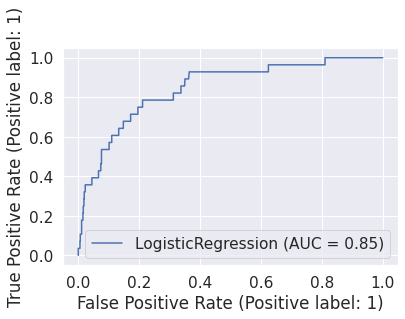

In [14]:
## Check performance: ROC curve
plot_roc_curve(log_regr, X_test, y_test)

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


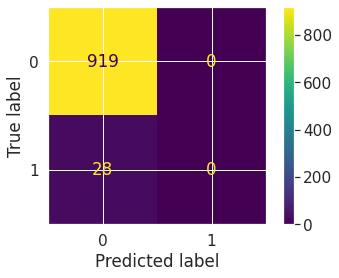

In [15]:
## Check performance: Confusion matrix
print('Confusion Matrix')
plot_confusion_matrix(log_regr, X_test, y_test)

In [16]:
## Check performance: Classification report
print(classification_report(y_test, log_regr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       919
           1       0.00      0.00      0.00        28

    accuracy                           0.97       947
   macro avg       0.49      0.50      0.49       947
weighted avg       0.94      0.97      0.96       947



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature: 0, Score: 0.26544
Feature: 1, Score: 1.04007
Feature: 2, Score: 0.34663
Feature: 3, Score: 0.23778
Feature: 4, Score: 0.81365
Feature: 5, Score: 0.07829
Feature: 6, Score: -0.00707
Feature: 7, Score: 1.25707
Feature: 8, Score: 0.19965
Feature: 9, Score: 0.63050
Feature: 10, Score: 1.62242
Feature: 11, Score: 0.08693
Feature: 12, Score: 0.01442
Feature: 13, Score: -0.07491
Feature: 14, Score: 0.06103
Feature: 15, Score: 0.01684
Feature: 16, Score: 0.77485
[(0, 'arthritis.type'), (1, 'gender'), (2, 'bmi'), (3, 'diabetes'), (4, 'smoke'), (5, 'marriage'), (6, 'medical.access'), (7, 'blood.pressure'), (8, 'covered.health'), (9, 'heart.attack'), (10, 'age_1'), (11, 'age_2'), (12, 'education_1'), (13, 'education_2'), (14, 'physical.activity_1'), (15, 'physical.activity_2'), (16, 'healthy.diet_1'), (17, 'healthy.diet_2')]


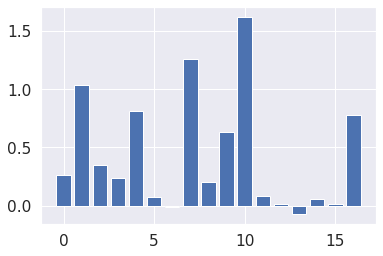

In [17]:
## Check performance: Feature importance

# get importance
importance = log_regr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# The positive scores indicate a feature that predicts class 1, 
# whereas the negative scores indicate a feature that predicts class 0.

## Create labels for feature importance plot
feat_num = list(range(0,18))
print(list(zip(feat_num, list(data.columns))))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Model evaluation

It looks like age and bloodpressure are the best predictors of HA. However, it seems like our model always (100% of the cases) predicts the sample to NOT have a heart attack. This leads to a high accuracy (97%) since there are a lot of true negatives, but in our confusion matrix we also see that the model has zero true positives. 
This would make this a bad model, as it is not able to predict HA succesfully at all.

This result is however not surprising, since using a "vanilla" logistic regression with default settings might not be sensitive enough to pick up and properly weight the small amount of samples that have a HA in the original dataset or handle many covariates.
Let's see if a different model would be able to perform better!


## Part 2: How can we measure the quality of the model? 
There are multiple ways to check model performance. We can use classification metrics or convenience methods (e.g. creating reports) to do so. 
In the example here, I looked at the actual predictions, calculated model accuracy, looked at a ROC curve, confusion matrix and lastly created a classification report. Note that one should look at multiple measurements of model performance to get a good feeling for the quality of the model.

The predictions tell us the predicted probability of the logistic regression for each case. The first column of the output of predict_proba is P(HA = 0), and the second column is P(HA = 1). Looks like all cases have a high probablity for being scored a 0. 

The model accuracy tells us the number of classifications that are correctly predicted divided by the total number of predictions made. This is very high, since most of the cases are indeed truely 0. However, we can note that in this case accuracy (alone) is not a very good measurement of quality as it gives us false confidence that it's a good model. We have to look at multiple measurements to gather more evidence on the model quality!

The ROC curve tells us the trade-off between the true positive rate and false positive rate using different probability thresholds. The higher the curve towards the top left corner, the better the model, also leading to a larger area under the curve (AUC). Looks like our model does not perform ideally by it's shape and the AUC value of .85 (the higher the better).  

The confusion matrix tells us the amount of true positives, true negatives, false positives ("Type I error") and false negatives ("Type II error"). We see mostly true negatives but zero true positives. This leads us to conclude it's a bad model, since it cannot predict HA at all. 

Lastly, the automatic classification report from the sklearn module gives us a summary of the precision, recall, F1 score for each class.
Precision is the ratio of true positives to the sum of true and false positives, in other words: the accuracy of positive predictions. Recall is defined as the ratio of true positives to the sum of true positives and false negatives, in other words: the fraction of positives that were correctly identified. The F1 score is a weighted mean of precision and recall such that the best score is 1.0 and the worst is 0.0.

In addition, more methods are available to do model testing and learn how to tune your model better. For example, cross validation methods can check perfomance on unseen data.




## Part 3: Which classification model did you choose and why is it good for the use case? Are there other models that would suit the use case and if so, why? 

Logistic regression is the standard, most popular approach when the goal is to predict an outcome with two categories and therefore a logical first choice for this type of use case. It is a fast, easy to understand method. However, we have noticed that our default model performs very poorly. Before switching to a new model, one should consider changing the parameters of the default model first, to see if performance increases. One could for example try to weight the HA cases, such that those cases that are 1 (HA) are considered more strongly. Alternatively, one could equalize the number of 0(no-HA) and 1(HA) cases in the training set and perform the training/testing steps multiple times. 

In the end, there are multiple alternatives to use on this type of binary-outcome classification problems instead of logistic regression, which may perform better. Each model comes with its own set of pros and cons. 
Given the rather small dataset, a neural network would not be well-suited. However, one could consider other methods that work better with many covariates such as K-Nearest Neighbor. Alternatively, for classification problems, tree-based models (such as gradient boosting) may outperform logistic regression performance, where libraries such as XGBoost win "practically every competition in the structured data category" according to Anthony Goldbloom, founder and CEO of Kaggle.

Since our data is categorical in nature, the library CatBoost may be helpful as it provides a gradient boosting framework which attempts to solve for categorical features specifically. 



Reference:
https://www.import.io/post/how-to-win-a-kaggle-competition/





## Part 4:	Please compare your model with at least one other model and explain the differences.

Let's create an CatBoost model to compare.
Since CatBoost can work with the original categorical data, let's see how it works with the original data containing the categorical variables.


### Data splitting


In [18]:
## Split the orig data new
## Create two datasets containing all either the data except the outcome (HA) variable, or only the outcome variable
## Remove the first column (uninformative)
copy_orig_data = copy_orig_data.iloc[: , 1:]

X_o = copy_orig_data.drop('heart.attack', axis=1)
y_o = copy_orig_data['heart.attack']

## Here we perform the split
# Since our outcome variable is unbalanced, we should stratisfy the split
X_o_train, X_o_test, y_o_train, y_o_test = train_test_split(X_o, y_o, random_state=1, stratify=y)


In [19]:
## Note which variables are categorical for CatBoost input
cat_features = list(range(0, X_o.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


### CatBoost Classifer

In [20]:
## Run CatBoost Classifier
model = CatBoostClassifier(iterations=200, learning_rate=0.05, random_seed=1, loss_function="Logloss")
model.fit(X_o_train, y_o_train,
          cat_features=cat_features,
          eval_set=(X_o_test, y_o_test), 
          verbose=50)


0:	learn: 0.5951981	test: 0.5971251	best: 0.5971251 (0)	total: 56.3ms	remaining: 11.2s
50:	learn: 0.1033053	test: 0.1137295	best: 0.1137295 (50)	total: 261ms	remaining: 764ms
100:	learn: 0.0902052	test: 0.1093486	best: 0.1093486 (100)	total: 496ms	remaining: 486ms
150:	learn: 0.0824670	test: 0.1075870	best: 0.1074648 (149)	total: 728ms	remaining: 236ms
199:	learn: 0.0750012	test: 0.1079517	best: 0.1074648 (149)	total: 991ms	remaining: 0us

bestTest = 0.1074648005
bestIteration = 149

Shrink model to first 150 iterations.


In [21]:
## Check performance
model.predict_proba(X_o_train)

# How many unique predictions are there?
list(set(model.predict(data=X_o_test)))

['No']

In [22]:
## Check performance: accuracy score
train_score = accuracy_score(y_o_train, model.predict(X_o_train)) * 100
test_score  = accuracy_score(y_o_test,  model.predict(X_o_test))  * 100

print("Training accuracy score: {}".format(train_score))
print("Test accuracy score: {}".format(test_score))

Training accuracy score: 97.18409010911651
Test accuracy score: 97.04329461457233


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


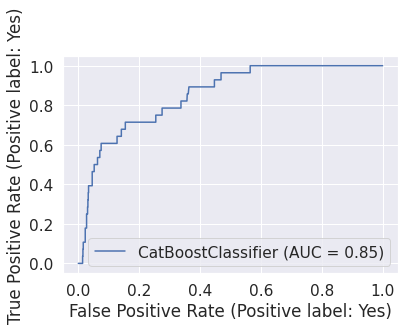

In [23]:
## Check performance: ROC curve
plot_roc_curve(model, X_o_test, y_o_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


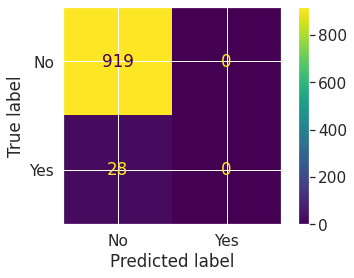

In [24]:
## Check performance: Confusion matrix
plot_confusion_matrix(model, X_o_test, y_o_test)

In [25]:
## Check performance: Classification report
print(classification_report(y_o_test, model.predict(X_o_test)))

              precision    recall  f1-score   support

          No       0.97      1.00      0.98       919
         Yes       0.00      0.00      0.00        28

    accuracy                           0.97       947
   macro avg       0.49      0.50      0.49       947
weighted avg       0.94      0.97      0.96       947



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
## Check performance: Feature importance
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,blood.pressure,18.411013
1,age,18.359884
2,gender,16.337261
3,smoke,11.925798
4,covered.health,8.770221
5,physical.activity,6.139299
6,healthy.diet,6.104310
7,education,4.120673
8,marriage,3.410876
9,bmi,2.475476


### Model evaluation

It looks like our CatBoost model performs very similarly to our simple logistic regression. Again, age and bloodpressure are the best predictors of HA. Again, it seems like our model always (100% of the cases) predicts the sample to NOT have a heart attack. This leads to the same high accuracy (97%) since there are a lot of true negatives, and in our confusion matrix we again see that the model has zero true positives. 
This would make also this model a bad model, as it is not able to predict HA succesfully.

As mentioned before, we should perhaps better weight the outcome variable due to the class imbalance. Let's have a look if that helps us!




## Part 4.2: Let's try to increase performance using weights

Given the major class imbalance, let's see if the performance increases of we add weights. We will weight the "no HA" values with a low weight and the "HA" values with a higher weight. 




Training accuracy score: 95.74093629003872
Test accuracy score: 94.50897571277719


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


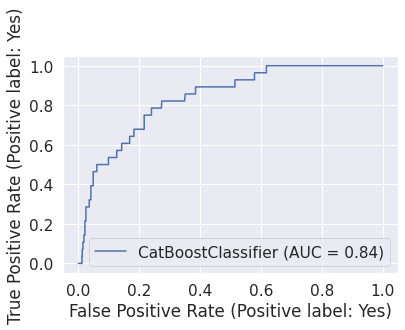

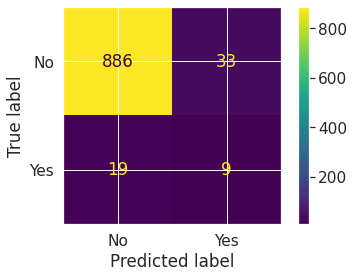

In [27]:
## Run CatBoost Classifier
model = CatBoostClassifier(iterations=200, learning_rate=0.05, random_seed=1, loss_function="Logloss", class_weights=[0.1, 0.9])
model.fit(X_o_train, y_o_train,
          cat_features=cat_features,
          eval_set=(X_o_test, y_o_test),
          verbose = False)

## Check performance
model.predict_proba(X_o_train)

# How many unique predictions are there?
list(set(model.predict(data=X_o_test)))
## Check performance: accuracy score
train_score = accuracy_score(y_o_train, model.predict(X_o_train)) * 100
test_score  = accuracy_score(y_o_test,  model.predict(X_o_test))  * 100

print("Training accuracy score: {}".format(train_score))
print("Test accuracy score: {}".format(test_score))

## Check performance: ROC curve
plot_roc_curve(model, X_o_test, y_o_test)

## Check performance: Confusion matrix
plot_confusion_matrix(model, X_o_test, y_o_test)


In [28]:
## Check performance: Classification report
print(classification_report(y_o_test, model.predict(X_o_test)))


              precision    recall  f1-score   support

          No       0.98      0.96      0.97       919
         Yes       0.21      0.32      0.26        28

    accuracy                           0.95       947
   macro avg       0.60      0.64      0.61       947
weighted avg       0.96      0.95      0.95       947



In [29]:
## Check performance: Feature importance
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,blood.pressure,16.899662
1,age,15.498080
2,gender,15.422741
3,smoke,14.447575
4,covered.health,6.623553
5,healthy.diet,6.024986
6,physical.activity,5.939705
7,education,5.416956
8,marriage,5.158483
9,bmi,3.144068


### Model evaluation

It looks like the model performs a bit more natural after adding the weights. As expected, the accuracy will be lower since we will have more predictions for HA, leading to more false positives. 
The main difference is that this model now has some true positives, which is more fitting to the truth. 

Ultimately, more techniques should be used to optimise the model and finetune the parameters such as adjusting learning rate, number of trees, tree depth etc. using for example grid search. 




## Part 5:	Is Rheumatoid arthritis a good predictor for heart attack? Are there other confounders that cloud the predictive power of the feature? How could we find them?

From our initial feature importance measurements we can deduce that arthritis is not a very good predictor for HA. 
However, this alone cannot tell us if this is the true predictive power of arthritis on HA. 
We can imagine that mostly older individuals will have arthritis, therefore we could expect this variable to be potentially highly correlated to age and thus overlapping variance could already be explained by age. In continous variables we would speak of multicollinearity, but since categorical features cannot be linearly related, we check for independence between our variables. 
In other words, the variable arthritis can be correlated to other predictors. Even though we could potentially find a high predictive power for our model, if our predictor variables are not independent, statistically, we cannot conclude that individually the predictors have an effect on the outcome measurement. We cannot really tell the individual contribution of the related variables.

Let's test for independence in our variables by calculating chi-square value to see if the variables are related.


In [ ]:
CrosstabResult=pd.crosstab(index=data['arthritis.type'],columns=data['age_1'])
print(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', float(ChiSqResult[1]))

for cols in data:
    nl = "\n"

    ## Build crosstab between arthritis and all other variables
    crosstab = pd.crosstab(data[f"{cols}"], data['arthritis.type'])
    print(crosstab, nl)
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")


It looks like arthritis is related to age as expected. We find however that more variables are related to arthritis as well. This could cloud the predictive power of arthritis. A solution to this problem would be to reduce the amount of dimension. One could use PCA or factor analysis methods to find the main dimensions/components/factors contribute to the predictive power of the model.
  